# <center> Analyzing TV Show data using APIs and ETL processes
### <center> DS 3002 Project 1a
### <center> Thomas Burrell (tmb9ccd)

 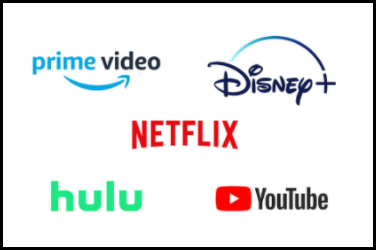

## About the data

The data is pulled from TVMAZE's API. It is a REST API that I accessed using requests.get(url).text. It contains data on TV's most popular shows in the US. Some of the variables include runtime, genre, languages, and many more. 

## Importing Packages

In [1]:
import os
import datetime
import pymongo
import pprint
import pandas as pd
import pymysql
from pymysql.constants import ER
import requests
import json
import csv
import matplotlib.pyplot as plt
from urllib.request import urlopen
from sqlalchemy import create_engine

## Connecting to local MongoDB database

In [2]:
host_name = "localhost"
port = "27017"

try:
    conn_str = f"mongodb://{host_name}:{port}/"
    client = pymongo.MongoClient(conn_str)
except ValueError:
    print("Make sure your port number is correct, then retry")

## Create new database: "TV_data" and collection: "Shows"

In [3]:
db = client["TV_data"]
collection = db['Shows']

## Pull JSON from API and insert into "Shows" collection in MongoDB

In [4]:
try:
    response = requests.get('https://api.tvmaze.com/shows').text
    response_info = json.loads(response)
    collection.insert_many(response_info)
except ConnectionError:
    print("Cannot connect to website, check the url and database connection")
except TypeError:
    print("Error: Make sure you spelled the url correctly")
except:
    print("Something else went wrong")

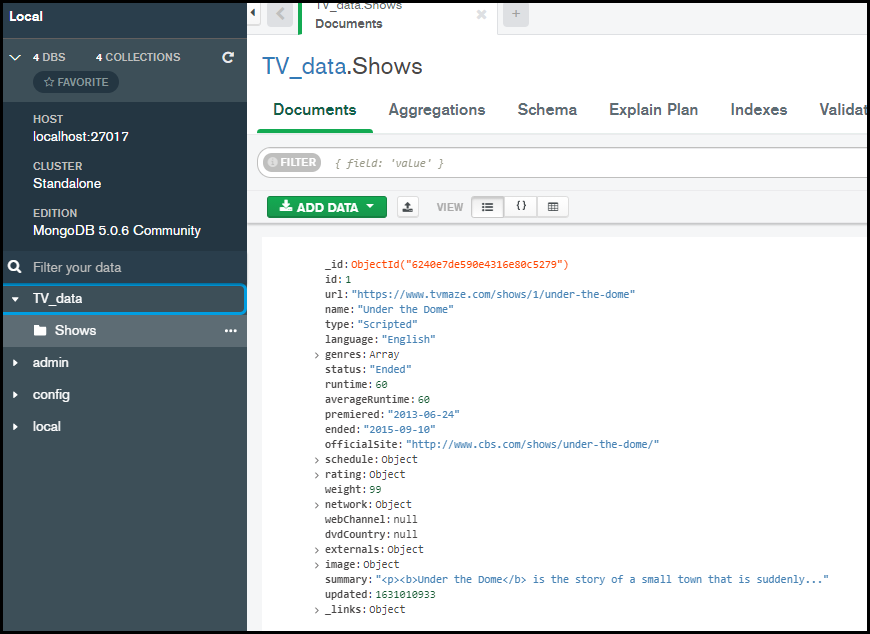

## Converting JSON to CSV / Reducing the number of columns

In [34]:
#Use pandas to turn a json file to a dataframe
shows_df = pd.read_json(response)

# Get specific columns
shows_df = shows_df[['id','name','runtime','averageRuntime','language','ended']]

# Write shows_df to a csv file 
shows_df.to_csv('shows.csv')

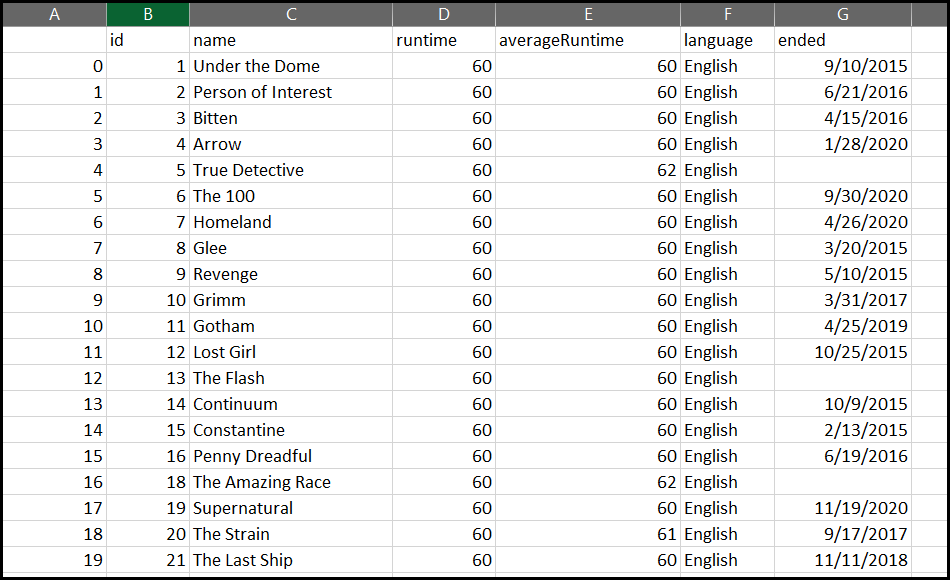

## Converting CSV to JSON

In [35]:
data = open('shows.csv').readlines()
shows_json = json.dumps(list(csv.reader(data)))

with open('json_shows_data.json', 'w') as outfile:
    outfile.write(shows_json)

    

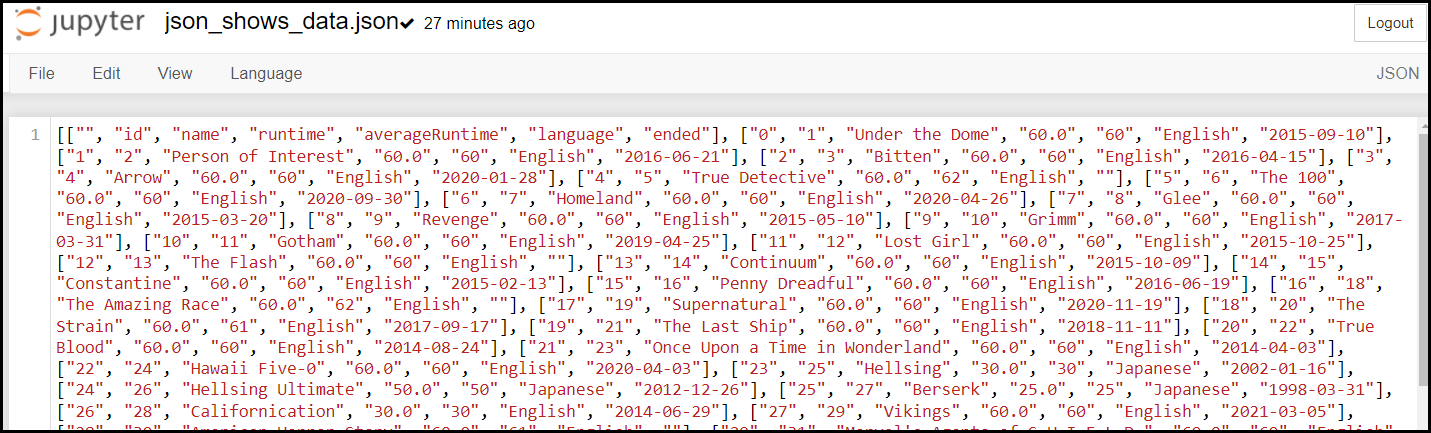

## Converting modified "shows_df" dataframe to SQL database table

### Connecting to mySQL 

In [36]:
host_name = "localhost"
host_ip = "127.0.0.1"
port = "3306"
user_id = "root"
pwd = "dwkd82!hh"

src_dbname = "Shows"
dst_dbname = "Shows"

In [37]:
def get_dataframe(user_id, pwd, host_name, db_name, sql_query):
    conn_str = f"mysql+pymysql://{user_id}:{pwd}@{host_name}/{db_name}"
    sqlEngine = create_engine(conn_str, pool_recycle=3600)
    connection = sqlEngine.connect()
    dframe = pd.read_sql(sql_query, connection);
    connection.close()
    
    return dframe


def set_dataframe(user_id, pwd, host_name, db_name, df, table_name, pk_column, db_operation):
    conn_str = f"mysql+pymysql://{user_id}:{pwd}@{host_name}/{db_name}"
    sqlEngine = create_engine(conn_str, pool_recycle=3600)
    connection = sqlEngine.connect()
    
    if db_operation == "insert":
        df.to_sql(table_name, con=connection, index=False, if_exists='replace')
        sqlEngine.execute(f"ALTER TABLE {table_name} ADD PRIMARY KEY ({pk_column});")
            
    elif db_operation == "update":
        df.to_sql(table_name, con=connection, index=False, if_exists='append')
    
    connection.close()
    
conn_str = f"mysql+pymysql://{user_id}:{pwd}@{host_name}"
sqlEngine = create_engine(conn_str, pool_recycle=3600)

sqlEngine.execute(f"DROP DATABASE IF EXISTS `{dst_dbname}`;")
sqlEngine.execute(f"CREATE DATABASE `{dst_dbname}`;")
sqlEngine.execute(f"USE {dst_dbname};")


### Inserting shows_df into mySQL

In [38]:
db_operation = "insert"
table_name = "shows_table"
primary_key = "id"
dataframe = shows_df

set_dataframe(user_id, pwd, host_name, dst_dbname, dataframe, table_name, primary_key, db_operation)

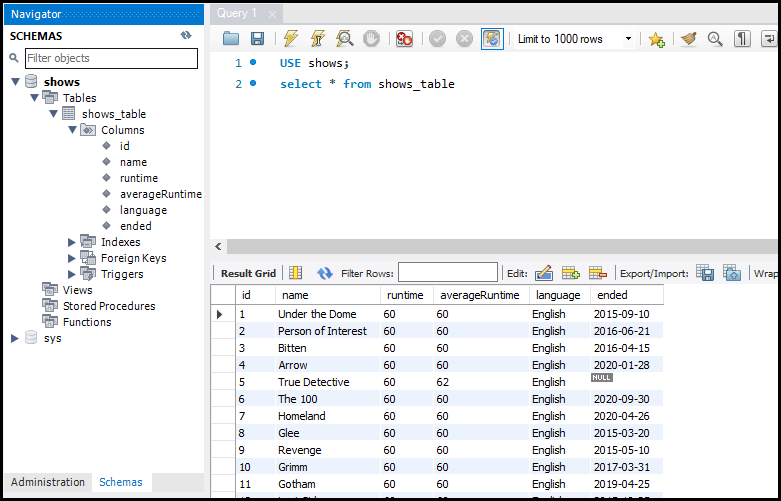

# Exploratory Data Analysis / brief summary

Finding the total number of records (documents)

In [39]:
total_count = db.Shows.count_documents({})
doc = print("Total number of documents : ", total_count)
doc

Total number of documents :  240


Total number of documents :  240

Finding the total number of columns (fields)

In [51]:
field_count = db.Shows.find()

count = 0
for i in field_count[0]:
    count += 1

print("Total number of fields : ", count)

Total number of fields :  24


 Total number of fields :  24

Finding the shows that have an average runtime greater than 60 minutes using MongoDB:

In [49]:
result_1 = db.Shows.find({
    "averageRuntime" : { "$gt" : 60}
})

emp_list = []
for i in result_1:
    emp_list.append(i['name'])
emp_list

['True Detective',
 'The Amazing Race',
 'The Strain',
 'American Horror Story',
 'Fargo',
 'Z Nation',
 'Outlander',
 'The Voice',
 'Dancing with the Stars',
 'The Walking Dead',
 'Game of Thrones',
 'Defiance',
 'The Biggest Loser',
 'Survivor',
 'The Affair',
 'The Leftovers',
 'Twin Peaks',
 'The Americans',
 'Fringe',
 'Battlestar Galactica',
 'Firefly',
 'Tyrant',
 'Rectify']

Finding the shows that have an average runtime greater than 60 minutes using pandas:

In [47]:
long_shows = shows_df[shows_df["averageRuntime"] > 60]
long_shows["name"]


4              True Detective
16           The Amazing Race
18                 The Strain
28      American Horror Story
30                      Fargo
35                   Z Nation
40                  Outlander
67                  The Voice
68     Dancing with the Stars
70           The Walking Dead
79            Game of Thrones
90                   Defiance
93          The Biggest Loser
109                  Survivor
120                The Affair
130             The Leftovers
148                Twin Peaks
149             The Americans
150                    Fringe
158      Battlestar Galactica
171                   Firefly
174                    Tyrant
212                   Rectify
Name: name, dtype: object

Finding the shows that have an average runtime greater than 60 minutes using SQL:

In [43]:
long_shows_sql = 'SELECT name FROM shows_table WHERE averageRuntime > 60;'
df_long_shows = get_dataframe(user_id, pwd, host_name, src_dbname, long_shows_sql)

df_long_shows

,name
0,True Detective
1,The Amazing Race
2,The Strain
3,American Horror Story
4,Fargo
5,Z Nation
6,Outlander
7,The Voice
8,Dancing with the Stars
9,The Walking Dead


### Distribution of runtime among all tv shows

Average runtime among all shows: 52 minutes

Average runtime among all shows: 52 minutes


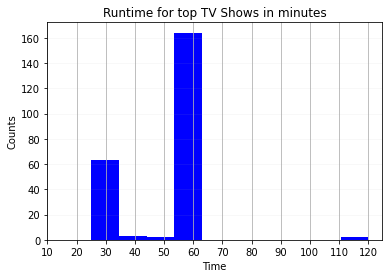

In [44]:
shows_df['runtime'].plot.hist(grid=True, bins=10, rwidth=10,
                  color='blue')
plt.title('Runtime for top TV Shows in minutes')
plt.xlabel('Time')
plt.ylabel('Counts')
plt.grid(axis='y', alpha=0.1)
plt.xticks([10,20,30,40,50,60,70,80,90,100,110,120])


# Average Run time Among all tv shows
mean_runtime = shows_df['runtime'].mean()
print("Average runtime among all shows:", round(mean_runtime), "minutes")

We can see that the overwhelming majority of TV Shows are 60 minutes, followed by TV Shows that are 30 minutes, and a few shows that are neither 30 or 60 minutes.

### Languages in TV Shows data

In [45]:
#languages = shows_df["language"].unique()
#for i in languages:
#    print(i)
    
num_lang = shows_df['language'].value_counts()
num_lang_eng = num_lang[0]
num_lang_jap = num_lang[1]
eng = "English"
jap = "Japanese"

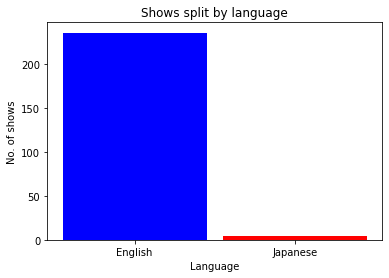

In [46]:
plt.bar([eng, jap], [num_lang_eng, num_lang_jap], color =['blue','red'],
        width = .9)
 
plt.xlabel("Language")
plt.ylabel("No. of shows")
plt.title("Shows split by language")
plt.show()

From the plot above, we can see that the overwhelming majority of shows have English as their language.